In [1]:
from os.path import join

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding
from keras.layers import LSTM, Bidirectional

WORK_DIR = "../Data/bioc_FH_training/"
PROCESSED_DIR = "../Data/processed/"
OBJECTS_DIR = '../objects/'

Using TensorFlow backend.


In [2]:
def load_re_data(file):
    with open(join(OBJECTS_DIR, file), 'r') as f:
        X, y = [], []
        for line in f:
            line = line.strip().split('\t')
            X.insert(0, line[1])
            y.insert(0, line[2])
    return X, y

X_re_train, y_re_train = load_re_data('re_train_data.txt')
X_re_valid, y_re_valid = load_re_data('re_valid_data.txt')

In [3]:
## elmo embedding
# with open(join(PROCESSED_DIR, 'doc_156.emb.pkl'),'rb') as f:
#     doc = pkl.load(f)

# keras
https://medium.com/southpigalle/simple-relation-extraction-with-a-bi-lstm-model-part-1-682b670d5e11

Input: 
https://www.kaggle.com/snlpnkj/bidirectional-lstm-keras !!!

In [4]:
embedding_size = 100
EMBEDDINT_FILE = f"../../../tools/glove/glove.6B.{embedding_size}d.txt"

max_features = 25000  # how many unique words to use
maxlen = 180          # max num of words in one training record

In [5]:
list_classes = ['FM_OBS', 'FM_OBS_N', 'OTHERS']
dict_classes = {label: i for i, label in enumerate(list_classes)}

In [6]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_re_train+X_re_valid)

X_tokenized_train = tokenizer.texts_to_sequences(X_re_train)
X_tokenized_valid = tokenizer.texts_to_sequences(X_re_valid)

len_X_train = list(map(len, X_tokenized_train))
len_X_valid = list(map(len, X_tokenized_valid))
print("Train: avg length:", np.mean(len_X_train), "\nmax:", np.max(len_X_train))
print("Valid: avg length:", np.mean(len_X_valid), "\nmax:", np.max(len_X_valid))

X_train = pad_sequences(X_tokenized_train, maxlen=maxlen)
X_valid = pad_sequences(X_tokenized_valid, maxlen=maxlen)

y_train = [dict_classes[label] for label in y_re_train]
y_valid = [dict_classes[label] for label in y_re_valid]

Train: avg length: 34.208188153310104 
max: 172
Valid: avg length: 33.850174216027874 
max: 183


In [7]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDINT_FILE))
word_index = tokenizer.word_index

In [8]:
all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()

embedding_matrix = np.random.normal(emb_mean, emb_std,
                                    (max_features, embedding_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

/home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [9]:
model = Sequential()
# modify as elmo embedding layer,
# with shape (batch_size, seq_len, dim)
model.add(Embedding(max_features,
                    embedding_size,
                    input_length=maxlen))
model.add(Bidirectional(LSTM(128,
                             dropout=0.5,
                             recurrent_dropout=0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
print(model.summary())

W0812 01:38:00.720392 140125239162624 module_wrapper.py:136] From /home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 01:38:00.972429 140125239162624 deprecation.py:506] From /home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0812 01:38:01.692318 140125239162624 module_wrapper.py:136] From /home/texuanw/softwares/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0812 01:38:01.717973 140125239162624 deprecatio

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 180, 100)          2500000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,734,753
Trainable params: 2,734,753
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
print('Training...')
batch_size = 32
epochs = 15
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    validation_data=[X_valid, y_valid])

Training...
Train on 1148 samples, validate on 287 samples
Epoch 1/15
1148/1148 [==============================] - 16s 14ms/step - loss: -0.2397 - acc: 0.0479 - val_loss: -2.5583 - val_acc: 0.0488
Epoch 2/15
1148/1148 [==============================] - 13s 12ms/step - loss: -3.6412 - acc: 0.0618 - val_loss: -4.8483 - val_acc: 0.1847
Epoch 3/15
1148/1148 [==============================] - 13s 11ms/step - loss: -4.9846 - acc: 0.3223 - val_loss: -5.2670 - val_acc: 0.2997
Epoch 4/15
1148/1148 [==============================] - 13s 12ms/step - loss: -5.4002 - acc: 0.3589 - val_loss: -5.7591 - val_acc: 0.3624
Epoch 5/15
1148/1148 [==============================] - 13s 12ms/step - loss: -5.7565 - acc: 0.4120 - val_loss: -5.9193 - val_acc: 0.3484
Epoch 6/15
1148/1148 [==============================] - 14s 12ms/step - loss: -5.9012 - acc: 0.4329 - val_loss: -6.0443 - val_acc: 0.3728
Epoch 7/15
1148/1148 [==============================] - 13s 12ms/step - loss: -6.0229 - acc: 0.4225 - val_loss: -

# Visulizing results of the training

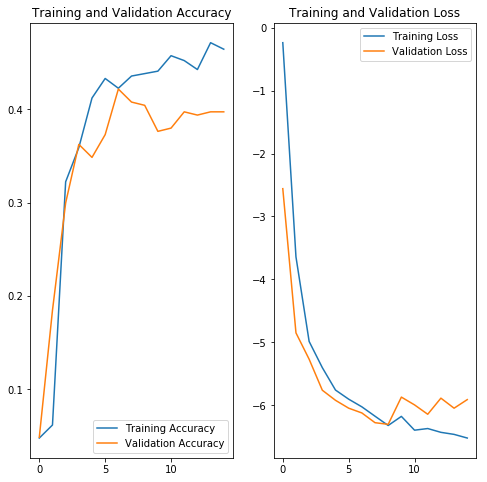

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# plt.savefig('./acc-loss.png')
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix
# # prediction_probas = model.predict(X_valid) 

predictions = model.predict(X_valid)
predictions = [1 if pred > 0.5 else 0 for pred in predictions]

k, wrong = 0, 0
for i, j in zip(predictions, y_valid):
    if i!=j:
        wrong += 1
        print("True: ", y_valid[k], '\n', X_re_valid[k], '\n')
    k+=1

# print(confusion_matrix(y_valid, predictions)) #from sklearn.metrics

# # print(classification_report(y_test, predictions, digits=3))

True:  2 
 @Relative$ had hypertension at 79. Father had @Disease$ in his 40s. 

True:  2 
 Distant paternal @Relative$ with thigh abscess in her 30s or 40s. Paternal uncle with some type of @Disease$ and died at age 45. 

True:  2 
 The patient has a healthy 5-year-old daughter and 9-year-old @Relative$. A brother, age 65, is healthy. Another brother, age 58, had uvulitis on his back a total of two times. The first of which occurred at age 42. A sister, age 50, had a malaria in in November 2009. Another sister, age 64, plans to have a Rubeola in February. The patient's mother was diagnosed with thymus atrophy at age 73 and died at age 80. She did not have any genetic testing. A maternal aunt was diagnosed with skrjabinemosis at age 59 and died at age 74. Another maternal aunt, who is currently in her 40s, was diagnosed with @Disease$ at age 81. 

True:  2 
 The patient's @Relative$ died in their 80s of cholera. The patient's father died at age 94 of @Disease$. 

True:  2 
 The patient

In [13]:
print(wrong, "wrong out of", len(y_valid))

173 wrong out of 287
